In [2]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pymc3 as pm
import theano.tensor as T

## Step 1 - Observe the Real Data

* The Data below is the real observations.
* We can see 2 peaks in the data, one with the center around 120 and the other with the center around 200.
* Felt like binominal distribution that an observation falls into either cluster 1 or cluster 2

[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


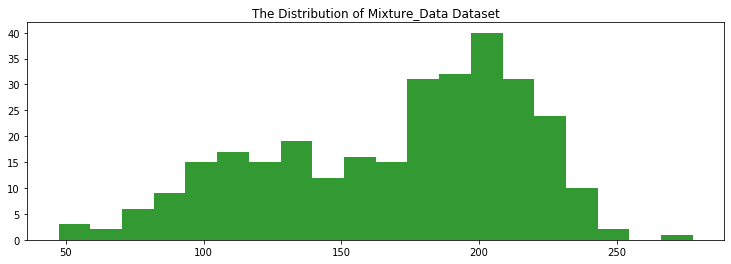

In [4]:
figsize(12.5, 4)
data = np.loadtxt("../data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="g", histtype="stepfilled", alpha=0.8)
plt.title("The Distribution of Mixture_Data Dataset")
plt.ylim([0, None]);
print(data[:10], "...")

## Step 2 - Generate the Data with Priors

### Assign Clusters
* `pm.Categorical`
  * Its parameter is a k-length array of probabilities that must sum to one 
  * Its value attribute is a integer between 0 and k-1 randomly chosen according to the crafted array of probabilities (In our case k=2)
* Since we don't know the probability to assign to which cluster in prior, so use uniform distribution here

In [5]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical("assignment", p, 
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))
    
print("prior assignment, with p = %.2f:" % p1.tag.test_value)
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.50:
[0 0 1 1 0 0 0 1 1 0]


### Assign `μ`， `σ` of the Cluster to each Observation

In [6]:
with model:
    sds = pm.Uniform("sds", 0, 100, shape=2)
    centers = pm.Normal("centers", 
                        mu=np.array([120, 200]), 
                        sd=np.array([10, 10]), 
                        shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    # combine with the real observations:
    observations = pm.Normal("obs", mu=center_i, sd=sd_i, observed=data)
    
print("Random assignments: ", assignment.tag.test_value[:10], "...")
print("Assigned center: ", center_i.tag.test_value[:10], "...")
print("Assigned standard deviation: ", sd_i.tag.test_value[:10], "...")
print("Observations: ", observations.tag.test_value[:10], "...")
print(data[:10], "...")

Random assignments:  [0 0 1 1 0 0 0 1 1 0] ...
Assigned center:  [120. 120. 200. 200. 120. 120. 120. 200. 200. 120.] ...
Assigned standard deviation:  [50. 50. 50. 50. 50. 50. 50. 50. 50. 50.] ...
Observations:  [115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...
[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


In [7]:
print(sds.tag.test_value)
print(centers.tag.test_value)

[50. 50.]
[120. 200.]


### Define Sampling Methods to Explore Define Space
* `Metropolis()` for our continuous variables
* `CategoricalGibbsMetropolis()` for categorical variable
* Sample 25000 iterations
  * The results are saved in `trace`, which records the value of specificed `vars` for each observation
    * These `vars` are, `p`, `sds`, `centers` and `assignment`

In [8]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.CategoricalGibbsMetropolis(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [centers]
>>Metropolis: [sds]
>>Metropolis: [p]
>CategoricalGibbsMetropolis: [assignment]
Sampling 4 chains, 0 divergences: 100%|█████████████████████████████████████| 102000/102000 [45:47<00:00, 37.12draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [15]:
print(trace['centers'].shape)
print(trace['p'].shape)
print(trace['sds'].shape)
print(trace['assignment'].shape)

(100000, 2)
(100000,)
(100000, 2)
(100000, 300)


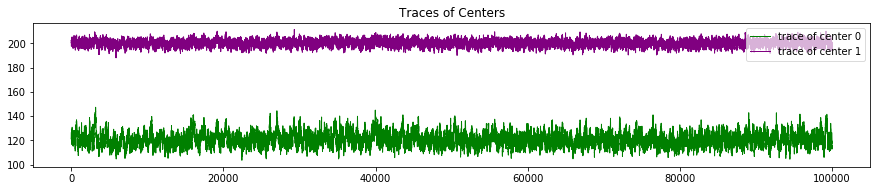

In [25]:
figsize(15, 9)
plt.subplot(311)
lw = 1
center_trace = trace["centers"]

plt.plot(center_trace[:, 0], label="trace of center 0", c='g', lw=lw)
plt.plot(center_trace[:, 1], label="trace of center 1", c='purple', lw=lw)
plt.title("Traces of Centers")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)